In [1]:
"""!git clone https://github.com/FabriDeCastelli/HLT-News-Category.git
! pip install keras-tuner

import os
os.chdir("/content/HLT-News-Category/src/test")"""

'!git clone https://github.com/FabriDeCastelli/HLT-News-Category.git\n! pip install keras-tuner\n\nimport os\nos.chdir("/content/HLT-News-Category/src/test")'

In [2]:
import warnings
import os
import sys

warnings.filterwarnings('ignore')
current_dir = %pwd

parent_dir = os.path.abspath(os.path.join(current_dir, '../..'))
sys.path.append(parent_dir)

In [3]:
from src.main.models.bidirLSMT import BidirectionalLSTM
from src.main.pipeline.functions import clean_text, stop_words_removal, tokenize
from src.main.utilities.utils import get_dataset, create_embedding_matrix, load_pretrained_embedddings, split_train_val_test
from sklearn.model_selection import train_test_split
import keras as K
from config.config import (
    TENSORBOARD_LOGS, 
    EMBEDDINGS_PATH, 
    glove_file, 
    google_file, 
    fastText_file, 
    VOCAB_SIZE
    )


import warnings
warnings.filterwarnings("ignore")

In [4]:
bidirLSTM = BidirectionalLSTM()

bidirLSTM.pipeline = [clean_text, stop_words_removal, tokenize]

inputs, targets = get_dataset(one_hot=True)
inputs = bidirLSTM.run_pipeline(inputs, save=False)

pretrained_embeddings = load_pretrained_embedddings(os.path.join(EMBEDDINGS_PATH, glove_file), "glove")
find_ratio, unmached_words = create_embedding_matrix(pretrained_embeddings)

# stratified train test split
x_train, x_val, x_test, y_train, y_val, y_test = split_train_val_test(inputs, targets, validation_size=0.2, test_size=0.1)


Pipeline execution time: 0:00:22.632627


In [5]:
import random

print("Find ratio:", find_ratio)
print("Unmached tokens count:", len(unmached_words))
print("Unmached words examples:\n" + str(random.sample(unmached_words, 10)))
print(str(random.sample(unmached_words, 10)))

Find ratio: 0.6487640754922174
Unmached tokens count: 31005
Unmached words examples:
["system'", 'right’s', "'mountbatten", 'neurosurgeon’s', 'loungy', "anarchy'", "'witness", 'fool’s', '‘obviously', "school's"]
['“compassionate', "'knowing", 'link\xa0to', "blaine's", "weekend'", "truckin'", "shipka's", "'consequential'", "cake'", "nikki's"]


In [6]:
callbacks = [
    K.callbacks.EarlyStopping(monitor='val_loss', patience=2),
    K.callbacks.TensorBoard(TENSORBOARD_LOGS.format(repr(bidirLSTM)))
]
bidirLSTM.grid_search(x_train, y_train, x_val, y_val ,callbacks=callbacks, n_iter=1, refit=False)

Reloading Tuner from /Users/francesco/Desktop/unipi/MAGISTRALE/human_language_technologies/HLT-News-Category/results/BidirectionalLSTM/BidirectionalLSTM/tuner0.json


In [7]:
%load_ext tensorboard
%tensorboard --logdir "{TENSORBOARD_LOGS.format(repr(bidirLSTM))}" --host localhost

Launching TensorBoard...

In [8]:
#bidirLSTM.evaluate(x_test, y_test)

In [9]:
import numpy as np
from sklearn.metrics import classification_report
from src.main.utilities import plotting


y_pred = bidirLSTM.predict(x_test)


339/339 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step


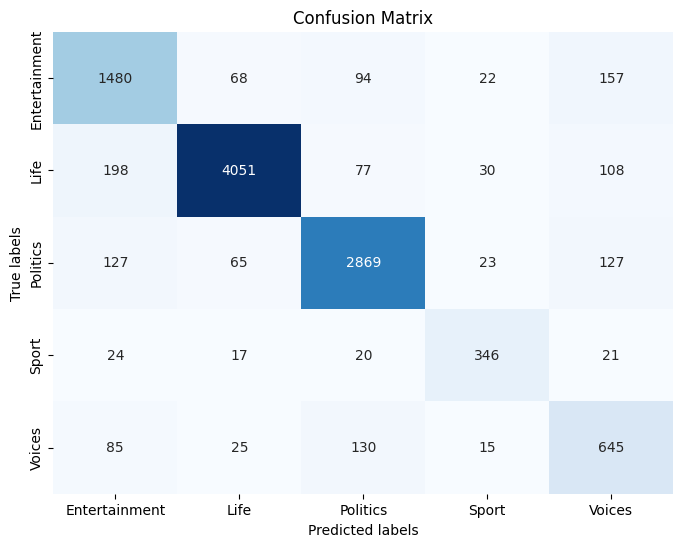

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1821
           1       0.96      0.91      0.93      4464
           2       0.90      0.89      0.90      3211
           3       0.79      0.81      0.80       428
           4       0.61      0.72      0.66       900

    accuracy                           0.87     10824
   macro avg       0.81      0.83      0.82     10824
weighted avg       0.87      0.87      0.87     10824



In [16]:
y_pred2 = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test.to_numpy(), axis=1)

plotting.plot_confusion_matrix(y_pred2, y_test2)

print(classification_report(y_pred2, y_test2))

In [12]:
bidirLSTM.save_model()